In [30]:
import seaborn as sns
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
n_samples = 10_00
x = np.linspace(-2, 2, n_samples)
y_prior = st.norm.rvs(loc=0, scale=1, size=n_samples)
y_likelyhood = st.norm.rvs(loc=5, scale=1.5, size=n_samples)
y_posterior = y_prior * y_likelyhood

df = pd.DataFrame({
    'x': np.repeat(x, 3),
    'y': np.concatenate([y_prior, y_likelyhood, y_posterior]),
    'grp': np.repeat(['prior', 'likelyhood', 'posterior'], n_samples)
})

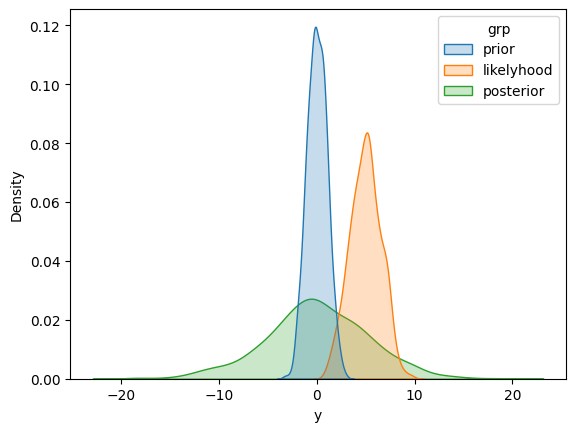

In [55]:
sns.kdeplot(data = df, x = 'y', hue='grp', fill=True);

In [285]:
from collections import namedtuple

ttest_params = namedtuple("TTestParams", "n nu mu sigma")

def calculate_posterior(prior, samples):
    n_samples = len(samples)
    nu_1 = prior.nu + n_samples
    n_1 = prior.n + n_samples

    mu_1 = update_mu(prior.mu, np.mean(samples), prior.n, n_samples)
    alpha_1, beta_1 = calc_inv_sigma(n_1, np.var(samples))

    sigma_1 = estimate_sigma(alpha_1, beta_1)

    posterior = ttest_params(n_1, nu_1, mu_1, sigma_1)
    return posterior

def update_mu(mu_0, mu_1, nu_0, nu_1):
    return ((nu_0 / (nu_0 + nu_1)) * mu_0) + ((nu_1 / (nu_0 + nu_1)) * mu_1)

def calc_inv_sigma(nu, sigma):
    alpha = nu / 2
    beta = (nu * sigma) / 2
    return alpha, beta

def estimate_sigma(alpha, beta):
    mean_sigma = st.invgamma.mean(alpha, scale=beta)
    return mean_sigma

def get_posterior_predictive(posterior, n_samples):
    return st.t.rvs(posterior.nu,
             loc=posterior.mu,
             scale=np.sqrt(posterior.sigma / posterior.n ),
            size=n_samples)

In [307]:
prior = ttest_params(5, 4, 0, 1)
samples = st.norm.rvs(3, 1, size=10)
posterior = calculate_posterior(prior, samples)
print(f"prior: {prior} \nposterior:{posterior}")

prior: TTestParams(n=5, nu=4, mu=0, sigma=1) 
posterior:TTestParams(n=15, nu=14, mu=2.113507792021691, sigma=0.43434114407473273)


In [314]:
n_samples = 10_000
prior_samples = get_posterior_predictive(prior, n_samples)
posterior_samples = get_posterior_predictive(posterior, n_samples)
likelihood_samples = st.norm.rvs(3, scale=1, size=n_samples)
groups = ['Prior', 'Likelihood', 'Posterior']
df = pd.DataFrame({
    'Samples': np.concatenate([prior_samples, likelihood_samples, posterior_samples]),
    'Group': np.repeat(groups, n_samples)
})

In [315]:
means = df.groupby('Group').mean()['Samples']

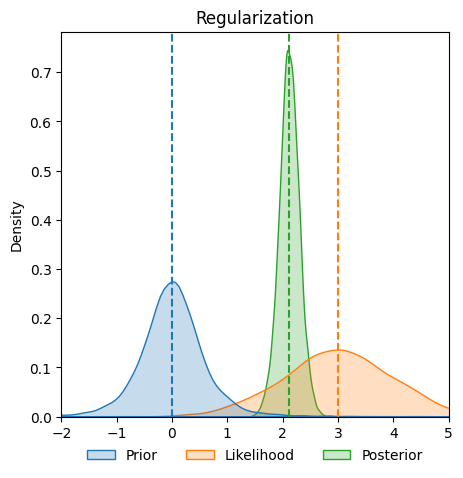

In [410]:
plt.figure(figsize=(5, 5))
ax = sns.kdeplot(data = df, x = 'Samples', hue='Group', legend='top', fill=True);
for i, k in enumerate(groups):
    plt.axvline(x=means[k],
            color=sns.color_palette()[i],
            ls='--')
plt.xlim(-2, 5);
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, title=None, frameon=False)
ax.set_title("Regularization")
plt.xlabel('');

In [401]:
np.random.seed(9)
prior = ttest_params(5, 4, 0, 1)
samples = st.norm.rvs(1, 1, size=51)
n_samples = 10_000

df_learning = pd.DataFrame({
    'Iteration': np.repeat(0, n_samples),
    'Sample': get_posterior_predictive(prior, n_samples)
})

for i in range(1, 6):
    noise = st.norm.rvs(i/10, 1, size=10)
    samples_i = samples[(i-1)*10:i*10] + noise
    posterior = calculate_posterior(prior, samples_i)
    df_learning = pd.concat([df_learning, pd.DataFrame({
        'Iteration': np.repeat(i, n_samples),
        'Sample': get_posterior_predictive(posterior, n_samples)
    })])
    prior = posterior
    

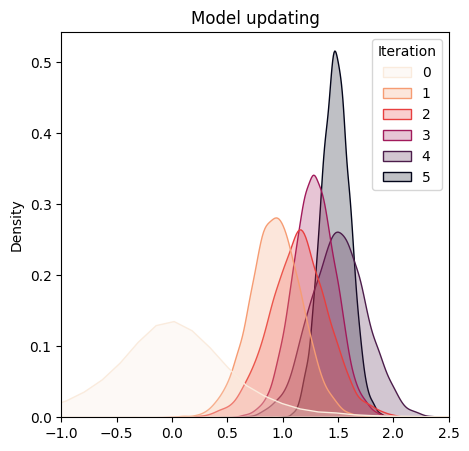

In [411]:
plt.figure(figsize=(5, 5))
color_palette = "rocket_r"
ax = sns.kdeplot(data = df_learning, x = 'Sample', hue='Iteration', legend='top', palette=color_palette, fill=True);
# for i, k in enumerate(df_learning['Iteration'].unique()):
#     plt.axvline(x=means[k],
#             color=sns.color_palette(color_palette)[i],
#             ls='--')
plt.xlim(-1, 2.5);
plt.title("Model updating")
# sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6, title=None, frameon=False)
plt.xlabel('');